# Numerické řešení Stokesova problému pomocí MKO

In [1]:
using PyPlot
import Base.-, Base.+, Base.*

In [2]:
type CartesianMesh
    nx 
    ny 
    Δx
    Δy
end

CartesianMesh(nx, ny) = CartesianMesh(nx, ny, 1.0/nx, 1.0/ny)

CartesianMesh

In [3]:
type Equation
    A
    x
    b
end

-(eq::Equation) = Equation(-eq.A, eq.x, -eq.b)
-(eq::Equation, b::Array{Float64,2}) = Equation(eq.A, eq.x, eq.b + b)
+(eq::Equation, b::Array{Float64,2}) = Equation(eq.A, eq.x, eq.b - b)
*(a::Float64, eq::Equation) = Equation(a*eq.A, eq.x, a*eq.b)

* (generic function with 155 methods)

In [4]:
function relax!(eqn::Equation, α)
    D = diag(eqn.A)
    for i=1:length(D) 
        eqn.A[i,i] /= α
    end
    eqn.b += (1-α)/α * reshape(D, size(eqn.x)) .* eqn.x
end

relax! (generic function with 1 method)

In [5]:
function solve!(eqn::Equation)
    dims = size(eqn.x)
    b = reshape(eqn.b, prod(dims))
    x = eqn.A \ b
    for i in eachindex(eqn.x)
        eqn.x[i] = x[i]
    end;
end;

In [6]:
type Field
    value
    mesh
    boundarycondition
end

Field(m :: CartesianMesh, bc) = Field( zeros(m.nx, m.ny), m, bc);

In [7]:
type Dirichlet
    value
end

type Neumann
    value
end

bndvalue(uin, Δ, bc::Dirichlet) = bc.value
bndvalue(uin, Δ, bc::Neumann) = uin + Δ * bc.value

ddncoeffs(Δ, bc::Dirichlet) = (-1/Δ, bc.value/Δ)
ddncoeffs(Δ, bc::Neumann) = (0, bc.value)


ddncoeffs (generic function with 2 methods)

In [8]:
msh3 = CartesianMesh(3,3)

CartesianMesh(3,3,0.3333333333333333,0.3333333333333333)

In [9]:
function createfields(msh)
    u = Field(msh, Dict( "top"=>Dirichlet(1), "left"=>Dirichlet(0), "right"=>Dirichlet(0), "bottom"=>Dirichlet(0)) );
    v = Field(msh, Dict( "top"=>Dirichlet(0), "left"=>Dirichlet(0), "right"=>Dirichlet(0), "bottom"=>Dirichlet(0)) );
    p = Field(msh, Dict( "top"=>Neumann(0), "left"=>Neumann(0), "right"=>Neumann(0), "bottom"=>Neumann(0)) );
    return (u,v,p)
end

createfields (generic function with 1 method)

In [10]:
function laplace(ν, u)
    dims = (u.mesh.nx, u.mesh.ny)
    n  = prod(dims)
    Δx, Δy = u.mesh.Δx, u.mesh.Δy 
    A = spzeros(n,n)
    b = zeros(u.value)
    
    # Loop over vertical faces
    for j = 1:dims[2]
        for i = 1:dims[1]-1
            owner = sub2ind( dims, i, j)
            neigh = sub2ind( dims, i+1, j)
            
            νf = (ν[owner]+ν[neigh]) / 2.0
            
            A[owner, owner] += -νf/Δx^2
            A[owner, neigh] +=  νf/Δx^2
            
            A[neigh, owner] +=  νf/Δx^2
            A[neigh, neigh] += -νf/Δx^2
        end
    end

    # Loop over horizontal faces
    for j = 1:dims[2]-1
        for i = 1:dims[1]
            owner = sub2ind( dims, i, j)
            neigh = sub2ind( dims, i, j+1)
            
            νf = (ν[owner]+ν[neigh]) / 2.0

            A[owner, owner] += -νf/Δy^2
            A[owner, neigh] +=  νf/Δy^2
            
            A[neigh, owner] +=  νf/Δy^2
            A[neigh, neigh] += -νf/Δy^2
        end
    end

    # Loop over boundaries
    # - left / right
    for j = 1:dims[2]
        a, v = ddncoeffs(Δx/2, u.boundarycondition["left"])
#        a, v = ddncoeffs(Δx, u.boundarycondition["left"])
        
        owner = sub2ind( dims, 1, j)
        νf = ν[owner]
        A[owner,owner] += νf * a / Δx
        b[owner] -= νf * v / Δx

        a, v = ddncoeffs(Δx/2, u.boundarycondition["right"])
#        a, v = ddncoeffs(Δx, u.boundarycondition["right"])
        owner = sub2ind( dims, dims[1], j)
        νf = ν[owner]
        A[owner,owner] += νf * a / Δx
        b[owner] -= νf * v / Δx
    end

    # - top / bottom
    for i = 1:dims[1]
        a, v = ddncoeffs(Δy/2, u.boundarycondition["bottom"])
#        a, v = ddncoeffs(Δy, u.boundarycondition["bottom"])
        owner = sub2ind( dims, i, 1)
        νf = ν[owner]
        A[owner,owner] += νf * a / Δy
        b[owner] -= νf * v / Δy

        a, v = ddncoeffs(Δy/2, u.boundarycondition["top"])
#        a, v = ddncoeffs(Δy, u.boundarycondition["top"])
        owner = sub2ind( dims, i, dims[2])
        νf = ν[owner]
        A[owner,owner] += νf * a / Δy
        b[owner] -= νf * v / Δy
    end    
    
    Equation(A, u.value, b)
end

laplace(u) = laplace(ones(u.value), u)

laplace (generic function with 2 methods)

In [11]:
function ddx(p)
    dims = (p.mesh.nx, p.mesh.ny)
    Δx   = p.mesh.Δx
    grad = zeros(p.value)
    
    # Loop over vertical faces
    for j = 1:dims[2]
        for i = 1:dims[1]-1
            pf = (p.value[i,j] + p.value[i+1,j]) / 2.0
            
            grad[i,j]   += pf / Δx
            grad[i+1,j] -= pf / Δx
        end
    end

    # Loop over boundaries
    # - left / right
    for j = 1:dims[2]
        pf = bndvalue(p.value[1,j], Δx/2, p.boundarycondition["left"])
        grad[1,j] -= pf / Δx

        pf = bndvalue(p.value[end,j], Δx/2, p.boundarycondition["right"])
        grad[end,j] += pf / Δx
    end
    
    return grad
end

ddx (generic function with 1 method)

In [12]:
function ddy(p)
    dims = (p.mesh.nx, p.mesh.ny)
    Δy   = p.mesh.Δy
    grad = zeros(p.value)
    
    # Loop over horizontal faces
    for j = 1:dims[2]-1
        for i = 1:dims[1]
            pf = (p.value[i,j] + p.value[i,j+1]) / 2.0
            
            grad[i,j]   += pf / Δy
            grad[i,j+1] -= pf / Δy
        end
    end

    # Loop over boundaries
    # - bottom / top
    for i = 1:dims[1]
        pf = bndvalue(p.value[i,1], Δy/2, p.boundarycondition["bottom"])
        grad[i,1] -= pf / Δy

        pf = bndvalue(p.value[i,end], Δy/2, p.boundarycondition["top"])
        grad[i,end] += pf / Δy
    end
    
    return grad
end

ddy (generic function with 1 method)

In [13]:
uu,_,_ = createfields(msh3);

In [14]:
uuEqn = laplace(uu)
full(uuEqn.A)

9×9 Array{Float64,2}:
 -54.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0    0.0
   9.0  -45.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0
   0.0    9.0  -54.0    0.0    0.0    9.0    0.0    0.0    0.0
   9.0    0.0    0.0  -45.0    9.0    0.0    9.0    0.0    0.0
   0.0    9.0    0.0    9.0  -36.0    9.0    0.0    9.0    0.0
   0.0    0.0    9.0    0.0    9.0  -45.0    0.0    0.0    9.0
   0.0    0.0    0.0    9.0    0.0    0.0  -54.0    9.0    0.0
   0.0    0.0    0.0    0.0    9.0    0.0    9.0  -45.0    9.0
   0.0    0.0    0.0    0.0    0.0    9.0    0.0    9.0  -54.0

In [15]:
uuEqn.x

3×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [16]:
uuEqn.b

3×3 Array{Float64,2}:
 0.0  0.0  -18.0
 0.0  0.0  -18.0
 0.0  0.0  -18.0

In [17]:
solve!(uuEqn);
uu.value

3×3 Array{Float64,2}:
 0.0357143  0.15  0.464286
 0.0642857  0.25  0.635714
 0.0357143  0.15  0.464286

## Zkusebni uloha

In [18]:
msh100 = CartesianMesh(100,100);

u100,_,_ = createfields(msh100);

solve!( laplace(u100) - ones(100,100));

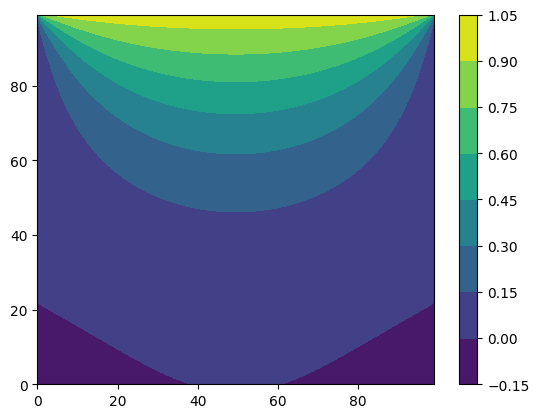

In [19]:
contourf(u100.value'); colorbar();

In [20]:
minimum(u100.value), maximum(u100.value)

(-0.002304604666260214,0.9882345668323598)

In [21]:
i,j = 50,50
(u100.value[i+1,j] - 2*u100.value[i,j] + u100.value[i-1,j]) / 0.01^2 + (u100.value[i,j+1] - 2*u100.value[i,j] + u100.value[i,j-1]) / 0.01^2

1.0000000000001674

## Algoritmus SIMPLE pro Stokesuv problem

\begin{align*}
- \Delta U &= - \nabla p, \\
\nabla U &= 0.
\end{align*}

Diskretizace:
$$
    a_C U_C = \sum_{f} a_F U_F + Q_C - \nabla p_C = H(U) - \nabla p_C,
$$

a tedy

$$
    U_C = \frac{1}{a_C} H(U) - \frac{1}{a_C} \nabla p_C.
$$

Definujme
$$
    \hat{U}_C = \frac{1}{a_C} H(U).
$$

Rovnice kontinuity

$$
    0 = \nabla U_C = \nabla(\hat{U}_C - \frac{1}{a_C} \nabla p_C)
$$

a tedy

$$
    \nabla(\frac{1}{a_C} \nabla p_C) = \nabla(\hat{U}_C).
$$

In [22]:
ν = 0.01

0.01

In [23]:
msh10 = CartesianMesh(10,10);
u,v,p = createfields(msh10);

In [24]:
uEqn = (-ν) * laplace(u);
vEqn = (-ν) * laplace(v);

In [25]:
solve!(uEqn + ddx(p));
solve!(vEqn + ddy(p));

In [26]:
Ac(eq::Equation) = reshape( diag(eq.A), size(eq.x) )
H(eq::Equation) =  eq.b + Ac(eq) .* eq.x - reshape( eq.A * reshape(eq.x, length(eq.x)), size(eq.x) )

H (generic function with 1 method)

In [27]:
ra = 1 ./ Ac(uEqn);

In [28]:
uBar = Field(ra * H(uEqn), u.mesh, u.boundarycondition);
vBar = Field(ra * H(vEqn), v.mesh, v.boundarycondition);

In [29]:
pEqn = laplace(ra, p) - (ddx(uBar) + ddy(vBar));
pEqn.A[1,1] += 1;

In [30]:
solve!(pEqn)

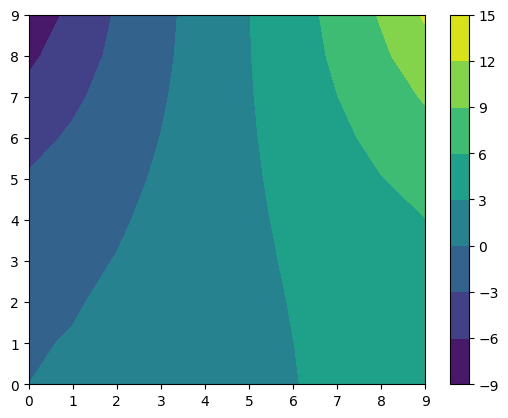

In [31]:
contourf(p.value'); colorbar();

In [32]:
u.value = uBar.value - ra .* ddx(p);
v.value = vBar.value - ra .* ddy(p);

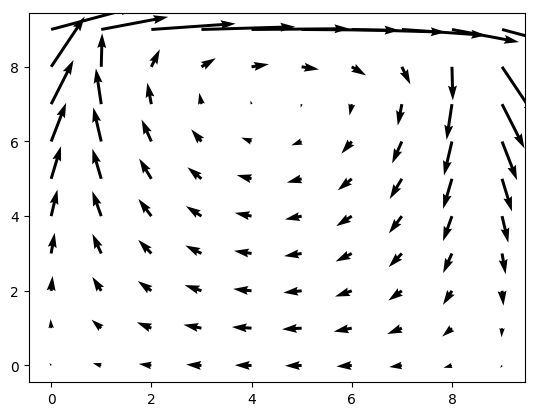

In [33]:
quiver(u.value', v.value');

In [34]:
ddx(u) + ddy(v)

10×10 Array{Float64,2}:
  0.470486    0.632206     1.25191    …   8.83657      3.94425     24.2579  
 -0.0447245  -0.684867    -1.15281       -8.31867    -14.9356     -14.2673  
  0.169517    0.00137359   0.0312        -0.399581    -0.662198     1.07414 
  0.0579018  -0.0653818   -0.0559458     -0.157328     0.0500383    0.681145
  0.0192023  -0.0221511   -0.0205896     -0.0290382    0.0574008    0.160068
 -0.0192023   0.0221511    0.0205896  …   0.0290382   -0.0574008   -0.160068
 -0.0579018   0.0653818    0.0559458      0.157328    -0.0500383   -0.681145
 -0.169517   -0.00137359  -0.0312         0.399581     0.662198    -1.07414 
  0.0447245   0.684867     1.15281        8.31867     14.9356      14.2673  
 -0.470486   -0.632206    -1.25191       -8.83657     -3.94425    -24.2579  

In [35]:
msh25 = CartesianMesh(25,25)

u,v,p = createfields(msh25)

α = 0.7
β = 0.3
ν = 1.0

for iter = 0:50
    
    uOld, vOld, pOld = copy(u.value), copy(v.value), copy(p.value)
    
    uEqn = (-ν)*laplace(u)
    vEqn = (-ν)*laplace(v)

    relax!(uEqn, α)
    relax!(vEqn, α)
    
    solve!(uEqn + ddx(p))
    solve!(vEqn + ddy(p))
    
    ra = 1 ./ Ac(uEqn);
    
    uBar = Field(ra .* H(uEqn), u.mesh, u.boundarycondition);
    vBar = Field(ra .* H(vEqn), v.mesh, v.boundarycondition);
    
    pEqn = laplace(ra, p) - (ddx(uBar) + ddy(vBar));
    pEqn.A[1,1] -= 1/(p.mesh.Δx*p.mesh.Δy)
    #pEqn.A[1,1] *= 2
    solve!(pEqn)
    
    p.value = (1-β) * pOld + β * p.value
    u.value = uBar.value - ra .* ddx(p)
    v.value = vBar.value - ra .* ddy(p)
    
    if rem(iter,5)==0
        nxny = u.mesh.nx*u.mesh.ny
        pRez = norm(pOld - p.value) / nxny
        uRez = norm(uOld - u.value) / nxny
        vRez = norm(vOld - v.value) / nxny
        println(iter, "\t", pRez, "\t", uRez, "\t", vRez)
    end
end

0	0.387395045045635	0.0031478519071338317	0.00028656343494647905
5	0.07896767164913437	0.0006360562686375097	7.413917532823907e-5
10	0.017188868225563994	0.00024391517292361291	0.00010503484325510955
15	0.016020688838191275	0.00011858751554687668	9.986264272283254e-5
20	0.007679221543774984	7.765799802236539e-5	7.229495643234727e-5
25	0.002646048787904135	5.6547503172775296e-5	5.0902735699141156e-5
30	0.0006242135068029813	4.198193461084148e-5	3.7264730059074956e-5
35	9.066539599077785e-5	3.136912203085224e-5	2.828435286570829e-5
40	4.848989511877762e-5	2.364215069589003e-5	2.1862519023271754e-5
45	4.931728574572222e-5	1.8005814480949076e-5	1.701891330514178e-5
50	5.247765022655709e-5	1.3842911232326461e-5	1.329110071417888e-5


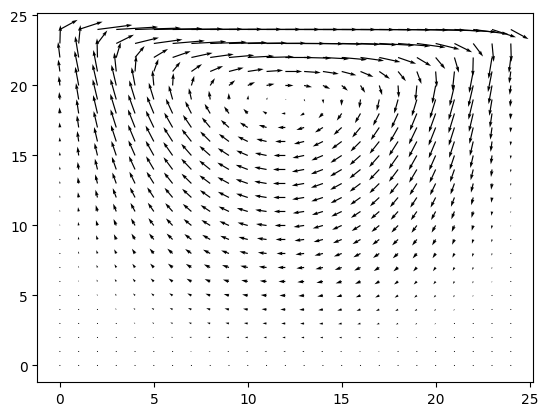

In [36]:
quiver(u.value', v.value');

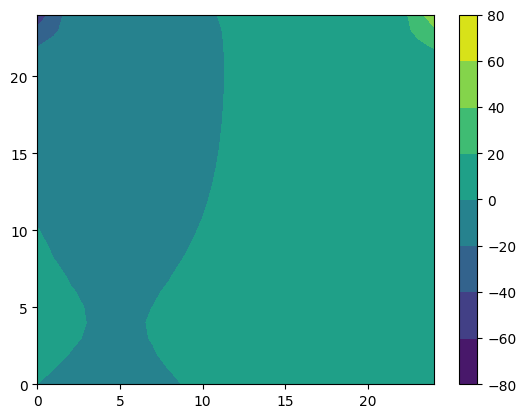

In [37]:
contourf(p.value'); colorbar();

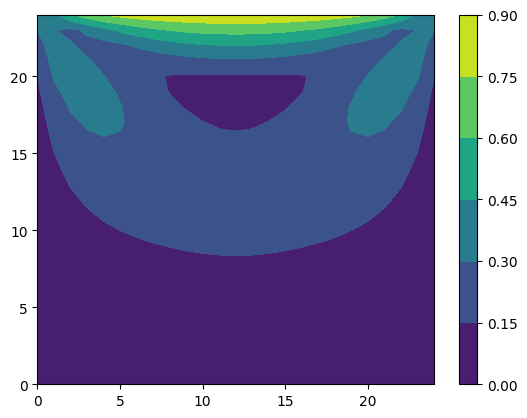

In [39]:
contourf(√(u.value.^2 + v.value.^2)'); colorbar();